<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Hash Your Way to Data Science Glory!
 <br>       
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 150px; height: auto; margin-top: 20pt;">
  <br>
    </p>
</header>

__This notebook contains all the code that was used for the Medium blog post https://medium.com/teradata/hash-your-way-to-data-science-glory-5cb07cea4d5f__

You can run it on https://clearscape.teradata.com  

# Intro

Everything in the world has a half-life, a concept that resonates deeply within the realms of both science and technology. This principle was underscored by many of my university professors, who advised us to prioritize understanding core concepts over chasing the latest tech trends, given their transient nature. One such enduring concept is hashing, whose significance in data science workflows I've only fully appreciated years after my exams.

Hashing lies at the heart of Teradata technology, particularly its capacity for massive parallel processing (MPP) (https://www.teradata.com/resources/white-papers/born-to-be-parallel-and-beyond) . This capability hinges on efficient data access and retrieval, powered by a robust hashing function. While the mechanics of hashing might remain behind the scenes for most users, gaining an understanding of how it works can be incredibly beneficial. 

In this blog post, I'll demonstrate through four use cases how hashing can be a game-changer in the workflow of a data scientist. These four use cases are:

1.	Pseudonymize a categorical feature
   
2.	Splitting data into random subsets for train, evaluate and test
   
3.	Encode a categorical feature with unknown number of values in buckets
   
4.	Encode a categorical feature with known number of values without collisions


Before that, let’s start with the basics. What is hashing and what are the qualities of a hashing function?


# About Hashing

In simple terms, a hash function is a special mathematical algorithm that takes input data of any size and produces a fixed-size string of characters, which typically looks like a random sequence of letters and numbers. Think of it as a unique digital fingerprint for the data. No matter how large or small the input is, the hash function generates a fixed-length output. For example, whether you're hashing a single word like "hello" or an entire book, the output (hash) will be of a consistent length.

Teradata's efficiency highly relies on its hashing function. Let's highlight some key properties of the Teradata hash function

- Deterministic: The same input will always produce the same output.
- Fast computation: It's quick to calculate the hash for any given data, hence insertion/ reading will be fast
- Non-invertible: It's practically impossible to reverse the process, meaning you can't easily figure out the original input from the hash output.
- Collision-resistant: It's extremely unlikely (though not impossible) that two different inputs will produce the same output hash. This depends on the length of the output token. When converted to an integer, the results from the HASHROW function can have over 4 billion different codes, 4,294,967,295 hash codes to be precise
- Uniform: When your input unique, such as a primary key, the output will be uniform, once you process it further with the modulo operator.

But let's not be just theoretic. It is much easier to grasp with a demo data set. For our demonstration, we will rely on the Adult dataset, also known as the "Census Income" dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/2/adult) . It comprises 48,842 instances with 14 features, aimed at predicting whether an individual's income exceeds $50,000 per year based on census data. The dataset includes a mix of categorical and integer feature types, covering demographic attributes such as age, work class, education, marital status, occupation, relationship, race, and sex.
 
To start with, we can use the ClearScape analytics demo environment (Sign up for free here: https://clearscape.teradata.com/), which comes with a Jupyter Hub environment and a Vantage Cloud instance.


First, let's create a database connection and populate a table in Vantage with the census income data set.

In [1]:
host = "enter your host name here, can be found on the ClearScape Experience Dashboard"
username = "demo_user"
password = "enter password"

In [2]:
# connecting to Vantage
import teradataml as tdml
eng = tdml.create_context(host = host, username=username, password = password)

In [3]:
try:
    import ucimlrepo
except:
    !pip install ucimlrepo
    import ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo 

In [5]:
# the census income dataset has got id 2, 
# see here for more info: https://archive.ics.uci.edu/dataset/2/adult
adult = fetch_ucirepo(id=2)

In [6]:
# data (as pandas dataframes) 
df = adult.data.features 
df["income"] = adult.data.targets.income.str.replace(".","") # some cleaning needed.
df.columns = [c.replace("-","_") for c in df.columns] 
df = df.reset_index().rename(columns={'index': 'row_id'})

In [7]:
# upload dataframe to Vantage
tdml.copy_to_sql(df, "census_income", if_exists='replace', primary_index="row_id")

# Use Case 1: "Hidden by Hash"

In exploring how hash functions benefit data science, we start with  **anonymizing categorical variables**. This technique is essential for protecting data privacy. By using hash functions, we transform sensitive details into anonymized forms. This protects personal and confidential information while allowing us to still carry out meaningful data analysis.

Let's consider an example where we want to combine three categorical variables—relationship, race, and sex—into one anonymized variable using hash encryption. Here's the code:

In [8]:
DF = tdml.DataFrame("census_income")

In [9]:
from sqlalchemy import func as f

In [10]:
DF_encrypted = (DF
    .select(["row_id", "relationship", "race", "sex"])
    .assign(demographic_encrypted = 
         f.abs(f.from_bytes(f.hashrow(
                                 DF.relationship.expression, DF.race.expression, DF.sex.expression ), 
                            "base10" 
         ).cast(type_=tdml.INTEGER)
              )))

Let's dive into the code, breaking it down to understand each step:

- `hashrow`: This function taps into the Teradata Vantage's built-in hashing capability, taking specified columns as input and returning a hexadecimal value. [Teradata Documentation on HASHROW](https://docs.teradata.com/r/Enterprise_IntelliFlex_VMware/SQL-Functions-Expressions-and-Predicates/Hash-Related-Functions/HASHROW)
- `from_bytes`: With the `"base10"` argument, this function converts the hexadecimal value into a numeric float value. [Teradata Documentation on FROM_BYTES](https://docs.teradata.com/r/Enterprise_IntelliFlex_VMware/SQL-Data-Types-and-Literals/Data-Type-Conversion-Functions/FROM_BYTES)
- `abs`: This function is used to eliminate any negative sign that might appear in the process. [Teradata Documentation on ABS](https://docs.teradata.com/r/Enterprise_IntelliFlex_VMware/SQL-Functions-Expressions-and-Predicates/Arithmetic-Trigonometric-Hyperbolic-Operators/Functions/ABS)
- `cast`: This final step ensures the output is formatted as an `INTEGER`. [Teradata Documentation on Data Type Conversions](https://docs.teradata.com/r/Enterprise_IntelliFlex_VMware/SQL-Data-Types-and-Literals/Data-Type-Conversions)

A handy tool in teradataml is the `show_query()` function. It can be attached to any DataFrame expression, allowing us to peek at the resulting SQL query. In our case, here's what it looks like:

If the hashing process avoids any collisions, it creates a consistent mapping. This means if a row has the same values across the three selected columns for hashing, the resulting hashed value will be the same as well. The key benefit here is that hashing obscures the original clear text values, which might often be sufficient for privacy purposes. However, it's worth noting that if someone is familiar with the original categories' (multivariate) distributions, they could attempt to backtrack to the original values.

Moreover, should the model ever be exposed, it becomes ineffective without knowledge of the specific characteristics of the hash function used. This adds an extra layer of security, as the model's utility is closely tied to the unique properties of the hashing technique employed.

In [11]:
print(DF_encrypted.show_query())

select row_id AS row_id, relationship AS relationship, race AS race, sex AS sex, abs(CAST(from_bytes(hashrow(relationship, race, sex), 'base10') AS INTEGER)) AS demographic_encrypted from "DEMO_USER"."ml__select__1723797671804863"


In [12]:
DF_encrypted

row_id,relationship,race,sex,demographic_encrypted
3018,Own-child,White,Male,1436029802
48023,Own-child,White,Male,1436029802
25755,Own-child,White,Male,1436029802
19719,Unmarried,White,Female,972160569
36889,Unmarried,White,Female,972160569
33871,Not-in-family,White,Female,234852469
8585,Unmarried,White,Female,972160569
22737,Husband,White,Male,211103861
39438,Husband,White,Male,211103861
28304,Husband,White,Male,211103861


# Use Case 2: "Precision in Partition" 

As we move to our second exploration of hash functions in data science, we turn our attention to effectively dividing datasets into **training, validation, and test sets**. By applying a hash function to a unique primary key for this division, we achieve not only incredible efficiency but also a level of reproducibility and consistency that enhances data analysis projects. This technique smoothly generates distinct subsets of data. Thanks to the predictable behavior of hash functions, we can ensure that each piece of data consistently finds its way into the same subset, allowing for accurate comparisons and solid evaluations of model performance. Here's the breakdown:

1. **Hashing Identifiers**: Start by calculating a hash value for each record's unique identifier. This could be a singular ID, a mix of different fields, or any attribute that uniquely defines a record.

2. **Determining the Split**: Transform the hash value into a numerical range (for instance, by applying modulo 6 to the hash value). Then, assign the record to the training, evaluation, or test set based on its range. For instance:
   - Assign records with a value of 0 to the test set (making up 16.7%).
   - Assign records with a value of 1 to the validation set (also 16.7%).
   - Assign records with values from 2 to 5 to the training set (comprising 66.7%).

Now, applying this to the census dataset:

1. **Hashing Identifiers**: We're in luck here; `row_id` serves as our primary key.
2. **Determining the Split**: We'll allocate two-thirds of our data to training and one-sixth to both validation and testing. This involves taking the modulo 6 of our integer hash value to ensure even distribution.

Let's see how swiftly we can put this into action, opting for SQL this time for a bit of variety.

In [13]:
DF_fold = tdml.DataFrame.from_query(
"""
SELECT
    -- create 6 equally sized buckets
    MOD(
        ABS(CAST(from_bytes(hashrow(row_id), 'base10') AS INTEGER)), 
        6) as rowid_hashbin,
    -- assign to folds as per requirement
    CASE rowid_hashbin 
        WHEN 0 THEN 'test' 
        WHEN 1 THEN 'evaluate' 
        ELSE 'train'
    END as fold,
    t.*
FROM
     census_income t
""")

In [14]:
DF_fold

rowid_hashbin,fold,row_id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1,evaluate,36889,55,Private,269763,Some-college,10,Divorced,Other-service,Unmarried,White,Female,0,0,10,United-States,<=50K
1,evaluate,8585,38,Private,168407,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,5721,0,44,United-States,<=50K
0,test,22737,30,Private,218551,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,>50K
0,test,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
5,train,3018,21,Private,231866,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,65,United-States,<=50K
2,train,28304,49,Private,315984,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
3,train,48023,19,Private,142037,11th,7,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,30,United-States,<=50K
5,train,25755,17,?,47407,11th,7,Never-married,?,Own-child,White,Male,0,0,10,United-States,<=50K
1,evaluate,14152,37,Private,234901,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,Germany,>50K
2,train,33871,58,Local-gov,158357,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K


Let's check to make sure our data splits are fair, meaning they don't have uneven distributions of the target labels. This step highlights the flexibility of teradataml, which seamlessly blends SQL and pandas-style syntax for an intuitive workflow. Given that our aggregated DataFrame has just 6 rows, we'll move it over to pandas for  visualization. This allows us to take a closer look and ensure our model training is based on balanced and unbiased data.

In [15]:
DF_fold_counts = DF_fold.select(["fold","income","row_id"]).groupby(["fold","income"]).count()

In [16]:
pddf_fold_counts_pd = DF_fold_counts.to_pandas()

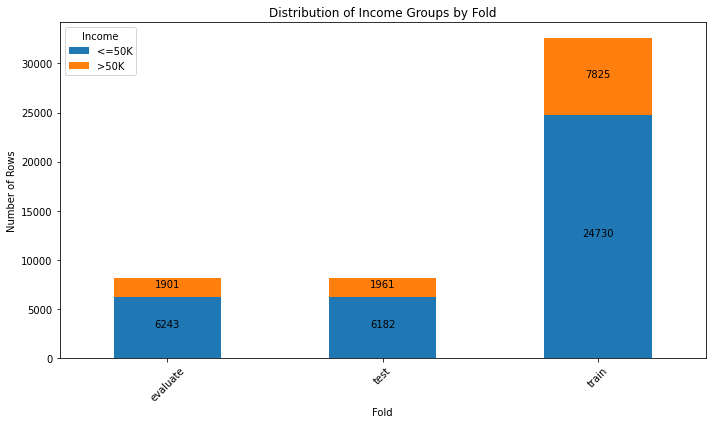

In [17]:
import matplotlib.pyplot as plt
pivot_df = pddf_fold_counts_pd.pivot(index='fold', columns='income', values='count_row_id').fillna(0)
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()/2 + bar.get_y()
    value = int(bar.get_height())
    ax.text(x, y, str(value), ha='center', )#va='bottom')

plt.title('Distribution of Income Groups by Fold')
plt.xlabel('Fold')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.legend(title='Income')
plt.tight_layout()
plt.show()

This looks great! The chart displayed paints a clear picture of our data split, confirming that we've met our goals for both the size of the splits and the evenness of the distribution. It shows the three subsets—train, test, and evaluate—each with a proportional mix of income categories, both <=50K and >50K. The 'train' fold is the largest, as intended, with the 'test' and 'evaluate' folds being smaller yet similar in size to each other. The balance across these folds suggests that our hash function has done its job well, assigning data points to each subset in a way that mirrors the overall composition of our dataset. 

# Use Case 3: "Italy, Peru and Portugal unified through hashing" 


In our journey through the practical uses of hash functions in data science, let's look at a challenge that often comes up with categorical data, like the `native_country` column in the census income dataset. This column has 43 different countries, and sometimes new ones appear that weren't seen during the model's training phase.

Other common methods for dealing with categories, like label encoding and one-hot encoding, have some drawbacks. Label encoding requires a fixed-size lookup-table. One-hot encoding creates a new column for each category, which can make our dataset much bigger and harder to work with, especially when new categories show up.

Hashing provides a clever way around these issues. It lets us **put many categories into a smaller number of groups**, even if that means some different categories end up in the same group. This is okay because it keeps our dataset manageable and our models flexible, able to handle new categories without needing a complete overhaul. For example, countries like Italy, Peru, and Portugal might all end up in the same group, but this simplicity helps us keep our model running fast and smoothly. Let's see how using hashing this way can make our models more straightforward and ready for whatever new data comes their way.

Our census income dataset contains some categorical variables, and the one that stands out as a candidate for feature is the native_country column. Currently there 43 distinct countries. In future during model deployment, there could be countries not seen during training, and the worst thing would be that our algorithm fails. 

For a start, we accept colissions, and we would like to only use 10 buckets derived from hashing, leading to 4.3 countries per bucket on average


In practical situations, you'll likely need to apply hash-encoding to more than just a single variable. So, the next step is to craft code that can handle this efficiently. We've learned that to achieve our transformation, we need to link together several functions. Fortunately, we can embody the spirit of good software practice—specifically, the DRY principle (Don't Repeat Yourself)—by designing a function that generates these derived columns for us.

In [18]:
def get_feature_hashbucket(thisDF, column_name, num_buckets=10):
    return f.abs(f.from_bytes(f.hashrow(thisDF[column_name].expression), "base10" 
                             ).cast(type_=tdml.INTEGER)) % num_buckets

In [19]:
columns_to_encode = ["relationship", "race", "sex", "native_country"]
my_kwargs = {(f"{colname}_encoded"):get_feature_hashbucket(DF,colname,10)
                for colname in columns_to_encode}

DF_hashbin = (DF
    .select(["row_id"]+ columns_to_encode)
    .assign(**my_kwargs))

In [20]:
DF_hashbin

row_id,relationship,race,sex,native_country,native_country_encoded,race_encoded,relationship_encoded,sex_encoded
25755,Own-child,White,Male,United-States,1,7,7,9
39438,Husband,White,Male,United-States,1,7,2,9
36889,Unmarried,White,Female,United-States,1,7,0,0
0,Not-in-family,White,Male,United-States,1,7,2,9
3018,Own-child,White,Male,United-States,1,7,7,9
33871,Not-in-family,White,Female,United-States,1,7,2,0
8585,Unmarried,White,Female,United-States,1,7,0,0
22737,Husband,White,Male,United-States,1,7,2,9
14152,Husband,White,Male,Germany,9,7,2,9
19719,Unmarried,White,Female,United-States,1,7,0,0


In [21]:
print(DF_hashbin.show_query())

select row_id AS row_id, relationship AS relationship, race AS race, sex AS sex, native_country AS native_country, abs(CAST(from_bytes(hashrow(native_country), 'base10') AS INTEGER)) MOD 10 AS native_country_encoded, abs(CAST(from_bytes(hashrow(race), 'base10') AS INTEGER)) MOD 10 AS race_encoded, abs(CAST(from_bytes(hashrow(relationship), 'base10') AS INTEGER)) MOD 10 AS relationship_encoded, abs(CAST(from_bytes(hashrow(sex), 'base10') AS INTEGER)) MOD 10 AS sex_encoded from "DEMO_USER"."ml__select__1723794446840016"


It looks like our method is taking shape—the initial results are in, and they're promising! The sample output doesn't reveal any collisions, but that might be due to certain values being more prevalent than others. To get a clearer view, we'll need to aggregate the table. 

In [22]:
DF_collisions = tdml.DataFrame.from_query(
"""
SELECT
    native_country_hashbin,
    COUNT ( native_country) no_countries_bin,
    TRIM(TRAILING ' ' FROM (XMLAGG(TRIM(native_country)|| ','
                           ORDER BY native_country) (VARCHAR(1000)))) as countries_list 
FROM (
    SELECT 
        DISTINCT (native_country),
        MOD(ABS(CAST(from_bytes(hashrow(native_country), 'base10') AS INTEGER)),10) as native_country_hashbin
    FROM
        census_income t
) t
GROUP BY native_country_hashbin
""")     

In [23]:
DF_collisions.sort("native_country_hashbin")

native_country_hashbin,no_countries_bin,countries_list
0,0,None
1,7,"Canada, England, France, Ireland, Puerto-Rico, Taiwan, United-States,"
2,5,"Ecuador, Honduras, Italy, Peru, Portugal,"
3,2,"Cambodia, China,"
4,7,"Columbia, El-Salvador, Greece, Guatemala, Hungary, Iran, Outlying-US(Guam-USVI-etc),"
5,4,"?, India, Japan, Laos,"
6,4,"Haiti, Holand-Netherlands, Hong, Jamaica,"
7,6,"Cuba, Mexico, Philippines, Poland, South, Thailand,"
8,3,"Dominican-Republic, Trinadad&Tobago, Vietnam,"
9,4,"Germany, Nicaragua, Scotland, Yugoslavia,"


We've run into collisions, which isn't surprising. As we saw, Italy, Peru, and Portugal all share hashbucket number 2. Before we pivot to our next use case, let's address a significant point: the choice of how many hash buckets to use.

If you're working with a modest number of bins and categories, you'll probably want to examine any collisions to decide if they're acceptable. If they're not, consider increasing your bucket count. Whether this extra step is worth it depends on how much it could speed up data preparation against your specific use case needs.

Think of the number of hash buckets for each feature as a dial you can turn in your data science process—it's essentially a hyperparameter you can tune!

When it comes to best practices for setting the size of hash buckets, it's all about the context and balancing act between performance and computational demands. More buckets mean fewer collisions but a larger feature space, which can bump up memory and processing requirements. On the flip side, a hash space that's too snug could lead to collisions that mask important details. A good rule of thumb is to begin with a hash space around ten times the size of the number of unique values you expect in your variable. From there, you can tweak as needed, based on real-world results and the computational power at your disposal. The sweet spot for hash bucket size is where you minimize information loss from collisions without unnecessary growth in dimensionality.

# Use Case 4: "Serving faster with Matcha Green Tea Salt" 

Whe've already seen that finding the right way to turn categories into numbers that our models can understand can be a challenge. Label encoding and one-hot encoding are common choices, but they're not perfect. They can struggle with a lot of different categories, either by needing a big table to keep track of them all (label encoding) or by making our dataset huge with too many columns (one-hot encoding). Plus, they don't handle new, unseen categories very well.

But as the saying goes, there's no free lunch - this applies to hash encoding too. However, sometimes we really need the best of both worlds: a way to **encode features efficiently without mixing up the categories we already know**.

We've mentioned a simple solution: use more buckets. But there's another clever technique - adding a "salt" to our categories. No, not the kind you cook with, but a special addition to our data that mixes things up. By attaching extra text to our category values, we create a kind of chaos that changes how they're sorted into buckets. Why does this help? Because with the right amount of shuffling, we can avoid mixing up our known categories in the same bucket.

To get this right, we need to understand a bit of probability theory - don't worry, it's not as scary as it sounds. Think about the birthday paradox, which shows us how likely it is for people in a group to share a birthday. It's a bit like our categories and buckets: the chance of two categories ending up in the same bucket (a "collision") depends on how we shuffle them and how many buckets we have. With the right adjustments, we can keep our known categories from colliding, making our data easier to work with and our models more accurate. Let's explore how this technique can help us manage our categories more effectively, even when they're numerous or new ones show up.


First up, let's wrap our heads around how likely it is for categories to end up in the same bucket, a.k.a., a collision. Look at the Python function that can figure out this probability for us, and also at the graph that shows what happens with different numbers of categories and buckets.

In [24]:
from math import factorial

def category_collision(num_buckets, num_categories):
    if num_buckets < num_categories:
        return 1.0
    else:
        return 1.0 - (factorial(num_buckets) / (factorial(num_buckets - num_categories) * (num_buckets ** num_categories)))


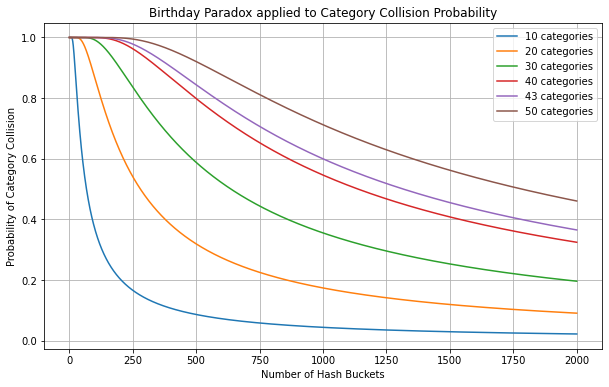

In [25]:
num_buckets_range = range(1, 2001)
num_categories_list = [10, 20, 30, 40, 43, 50]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each curve for the different number of categories
for num_categories in num_categories_list:
    probabilities = [category_collision(num_buckets, num_categories) for num_buckets in num_buckets_range]
    plt.plot(num_buckets_range, probabilities, label=f'{num_categories} categories')

# Add labels and title
plt.xlabel('Number of Hash Buckets')
plt.ylabel('Probability of Category Collision')
plt.title('Birthday Paradox applied to Category Collision Probability')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In our case, we're zooming in on the scenario with 43 categories because that's how many different `native_countries` we have in our dataset. Suppose we decide on 250 as our magic number of buckets. According to the graph (and the math behind it), if we do a simple hash with these 250 buckets, there's a 97.84% chance we'll see at least one overlap.

But what if we don't settle for just one try? What if we experiment with 100 different ways to assign these buckets by mixing in 100 unique "salts"? This strategy boosts our odds of hitting a combination without any collisions to 88.71%. Sounds like a plan, right? So, let's experiment with a whole hundred of different salts.

In [26]:
salts = ['TableSalt',  'SeaSalt',  'HimalayanPinkSalt',  'KosherSalt',  'CelticSeaSalt',  'FleurdeSel',  'BlackSaltKalaNamak',  'RedHawaiianSalt',  'BlackHawaiianSalt', 
 'SmokedSalt',  'FlakeSalt',  'SelGris',  'EpsomSalt',  'DeadSeaSalt',  'BolivianRoseSalt',  'PersianBlueSalt',  'AlaeaSalt',  'MaldonSalt',  'MurrayRiverSalt', 
 'CyprusBlackLavaSalt',  'DanishSmokedSalt',  'ChardonnayOakSmokedSalt',  'HawaiianBambooJadeSalt',  'SicilianSeaSalt',  'PeruvianPinkSalt',  'SelMelange', 
 'ApplewoodSmokedSalt',  'CherrywoodSmokedSalt',  'VanillaBeanSalt',  'SzechuanPepperSalt',  'LemonFlakeSalt',  'VintageMerlotSalt',  'GhostPepperSalt', 
 'LavenderRosemarySalt',  'MatchaGreenTeaSalt',  'TruffleSalt',  'PorciniMushroomSalt',  'GarlicSalt',  'OnionSalt',  'CelerySalt',  'HabaneroSalt', 
 'EspressoSalt',  'CinnamonSpiceSalt',  'IndianBlackSalt',  'BlueCheeseSalt',  'HickorySalt',  'AlderwoodSmokedSalt',  'AnchoChileSalt',  'BasilSalt',
 'ChiliLimeSalt',  'ChocolateSalt',  'CoconutGulaJawaSalt',  'CuminSalt',  'CurrySalt',  'FennelSalt',  'GingerSalt',  'HerbesdeProvenceSalt',  'JalapenoSalt', 
 'LimeSalt',  'MapleSalt',  'OrangeSalt',  'RoseSalt',  'SaffronSalt',  'SageSalt',  'SrirachaSalt',  'SumacSalt',  'TurmericSalt',  'WasabiSalt',
 'WhiskeySmokedSalt',  'WineSalt',  'YuzuSalt',  "ZaatarSalt",  'SmokedApplewoodSalt',  'BeechwoodSmokedSalt',  'NorwegianSeaSalt',  'BrittanySeaSalt', 
 'CornishSeaSalt',  'IcelandicSeaSalt',  'KoreanBambooSalt',  'MalaysianPyramidSalt',  'MexicanSeaSalt',  'NewZealandSeaSalt',  'PortugueseSeaSalt',
 'SouthAfricanSeaSalt',  'SpanishSeaSalt',  'ThaiFleurdeSel',  'VikingSmokedSalt',  'WelshSeaSalt',  'YakimaApplewoodSmokedSalt',  'OakSmokedSalt',  
 'PinkPeppercornSalt',  'LemonHerbSalt',  'ChipotleSalt',  'BourbonBarrelSmokedSalt',  'AguniSeaSalt',  'AmabitoNoMoshioSeaweedSalt', 
 'BlackTruffleSeaSalt',  'CaviarSalt',  'HarvestSalt',  'HawaiianRedAlaeaSalt',  'ItalianBlackTruffleSalt',  'JapaneseMatchaSalt', 
 'OliveSalt',  'PumpkinSpiceSalt',  'RosemarySalt',  'ShiitakeMushroomSalt',  'SicilianWhiteSalt',  'TibetanRoseSalt']

Next, we'll set up a temporary table listing all the distinct countries. We'll tweak our earlier function to consider our chosen "salt" by tacking it onto the end of each country name. Then, we'll run a check to see if we've managed to dodge any collisions with our new, salt-enhanced hashing method.

In [27]:
tdml.execute_sql("""
CREATE MULTISET VOLATILE TABLE countries_t AS 
(SELECT native_country FROM census_income GROUP BY native_country )
WITH DATA NO PRIMARY INDEX
ON COMMIT PRESERVE ROWS
""")

DF_countries = tdml.DataFrame("countries_t")

In [28]:
DF_countries

native_country
Scotland
Ecuador
Peru
El-Salvador
France
None
Ireland
Iran
Outlying-US(Guam-USVI-etc)
United-States


In [29]:
def get_feature_hashbucket_salted(thisDF, column_name, num_buckets=10, salt = ""):
    return f.abs(f.from_bytes(f.hashrow(f.concat(thisDF[column_name].expression, salt)), "base10" 
                             ).cast(type_=tdml.INTEGER)) % num_buckets

In [30]:
my_kwargs = {(f"native_country_{salt}") : get_feature_hashbucket_salted(DF_countries, "native_country",250, salt) 
                     for salt in salts}

DF_countries_hashbucket = (DF_countries
    .assign(**my_kwargs))

In [31]:
DF_countries_hashbucket.to_pandas().nunique().sort_values().tail(10)

native_country_CaviarSalt                42
native_country_HawaiianBambooJadeSalt    42
native_country_SelMelange                42
native_country_NewZealandSeaSalt         42
native_country                           42
native_country_TableSalt                 43
native_country_KosherSalt                43
native_country_MatchaGreenTeaSalt        43
native_country_OliveSalt                 43
native_country_FennelSalt                43
dtype: int64

Great news: we've got options on the table! Just like picking between table salt, kosher salt, matcha green tea salt, olive salt, or fennel salt to flavor our dishes, we can choose our "salt" for hashing to get that perfect, collision-free categorical encoding. And the best part? We don't need a massive number of buckets to make it happen. It's all about your preference now, like choosing the right seasoning for your meal.

Sure, it might sound like extra steps to take, but it's absolutely worth it when you're aiming to fine-tune your model or speed things up in production, especially when there are strict performance requirements to meet. Think of it as the secret ingredient that could give your model the edge it needs, ensuring it runs smoothly and quickly, just when you need it to.

# Summary

Hashing might not be a familiar concept to everyone, but understanding and leveraging it can be a real game-changer—if you know how to use it and when. In this blog post, we've taken a deep dive into how hashing works and why it's so important, especially when dealing with huge amounts of data in Teradata Vantage. We explored four key use cases: anonymizing data to protect privacy, splitting data sets for model training, and two ways of encoding categorical data to make it easier for machines to understand.

We started with the basics, showing how hashing turns any input into a fixed-size string, a bit like giving every piece of data its own unique fingerprint. This process is crucial for handling data quickly and safely. From there, we saw how hashing helps keep personal information private, ensures data is divided fairly for machine learning, and simplifies complex data into a format that's easy to work with, even introducing a clever "salt" trick to avoid mixing up different pieces of data.

Overall, we have shown that while hashing might seem a bit technical or obscure, it's actually a powerful tool in data science. It can make big data tasks more manageable, secure, and efficient, proving its value across a range of scenarios. So, the next time you're working with data, consider how hashing might help you achieve your goals more effectively.

Do not hesitate and try it out yourself by signing up for ClearScape Analytics Experience for free: https://clearscape.teradata.com/